<a href="https://colab.research.google.com/github/wogur9503/AI-bootcamp-/blob/main/Project_FuelEfficiencyPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **프로젝트 : 연비 예측 딥러닝**

간단한 데이터로 진행하기 때문에 머신러닝의 성능이 더 높을 수도 있다고 판단해서
머신러닝과 딥러닝의 성능 비교해보기로 함

In [14]:
!pip install -q seaborn

In [42]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# 머신러닝, 딥러닝 공통 작업(EDA, 데이터 분할, 데이터 확인, 기초 함수 작성)

#### 데이터 다운로드 & EDA

In [16]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [17]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### 결측치 확인 & 결측치 처리

In [18]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [19]:
dataset = dataset.dropna()

### 원핫인코딩
범주형 컬럼 "Origin" 원핫인코딩

In [20]:
# "Origin" 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다
origin = dataset.pop('Origin')

In [21]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### 데이터셋 분할

In [22]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### 데이터셋 조사

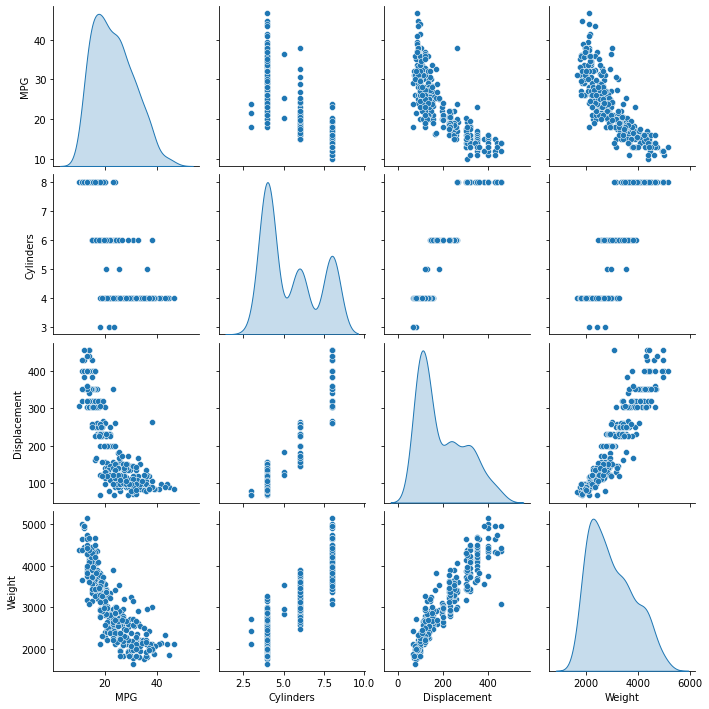

In [23]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [24]:
# 전반적인 통계 확인
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 특성과 레이블 분리

In [25]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### 데이터 정규화
가장 기본적인 형태로 정규화 처리

In [27]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [28]:
train_dataset.shape

(314, 9)

In [29]:
len(train_dataset.keys())

9

# **ML : Linear Regression & K-Fold**

In [38]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import KFold 

In [37]:
# 평가지표 = MAE
def MAE(true, pred):
    score = np.mean(np.abs(true-pred))
    return score

In [40]:
# 예측모델 인스턴스
lr = LinearRegression()

# KFold 함수를 이용해 폴드 개수를 할당(임의로 폴드 지정)
kfold = KFold(n_splits=5) 

In [43]:
cv_mae = [] # 각 cv의 rmse 점수를 계산하여 넣어줄 리스트 생성, 이후 RMSE값의 평균을 구하기 위해 사용
n_iter =0 # 반복 횟수 값을 초기 설정, 이후 프린트문에서 각 교차검증의 회차를 구분하기 위해 사용

# K값이 5이므로 이 반복문은 5번 반복하게 됨
for train_index, test_index in kfold.split(normed_train_data):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할, 인덱스 값 분할

    x_train, x_test = normed_train_data.iloc[train_index], normed_train_data.iloc[test_index] # feature로 사용할 값을 나눠진 인덱스값에 따라 설정
    y_train, y_test = train_labels.iloc[train_index], train_labels.iloc[test_index] # label로 사용할 값을 나눠진 인덱스값에 따라 설정
    
    lr = lr.fit(x_train, y_train) # 모델 학습
    pred = lr.predict(x_test) # 테스트셋 예측
    n_iter += 1 # 반복 횟수 1회 증가
    
    error = MAE(y_test, pred) # RMSE 점수 구하기
    train_size = x_train.shape[0] # 학습 데이터 크기
    test_size = x_test.shape[0] # 검증 데이터 크기
    
    print('\n{0}번째 교차 검증 RMSE : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, error, train_size, test_size))
    print('{0}번째 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_mae.append(error)
    
print('\n==> 이 방정식의 평균 에러(RMSE)는 {} 입니다.'.format(np.mean(cv_mae))) # 모델의 평균정확도 확인


1번째 교차 검증 RMSE : 2.3700679561363263,  학습 데이터 크기 : 251,  검증 데이터 크기 : 63
1번째 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]

2번째 교차 검증 RMSE : 2.578487546131306,  학습 데이터 크기 : 251,  검증 데이터 크기 : 63
2번째 검증 세트 인덱스 : [ 63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125]

3번째 교차 검증 RMSE : 2.7737548576655513,  학습 데이터 크기 : 251,  검증 데이터 크기 : 63
3번째 검증 세트 인덱스 : [126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188]

4번째 교차 검증 RMSE : 3.0396329887

#### 모델 생성

In [31]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001) # RMSprop < Adam / learning rate = 0.001(le-3)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [32]:
model = build_model()

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


#### 모델 실행

In [34]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.03101617],
       [ 0.02796389],
       [-0.01737969],
       [ 0.1233795 ],
       [-0.1073105 ],
       [ 0.06212573],
       [-0.12579975],
       [ 0.06161445],
       [-0.02049862],
       [ 0.14779519]], dtype=float32)

#### 모델 피팅

In [35]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정 표시
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

#### 모델 시각화

In [44]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.171745,0.919954,2.171745,8.611815,2.217132,8.611815,995
996,2.070814,0.922704,2.070814,8.340678,2.225638,8.340678,996
997,2.154877,0.974694,2.154877,8.570010,2.277171,8.570010,997
998,2.194996,0.998354,2.194996,8.534228,2.236926,8.534228,998
999,2.058693,0.922310,2.058693,9.017497,2.355173,9.017497,999


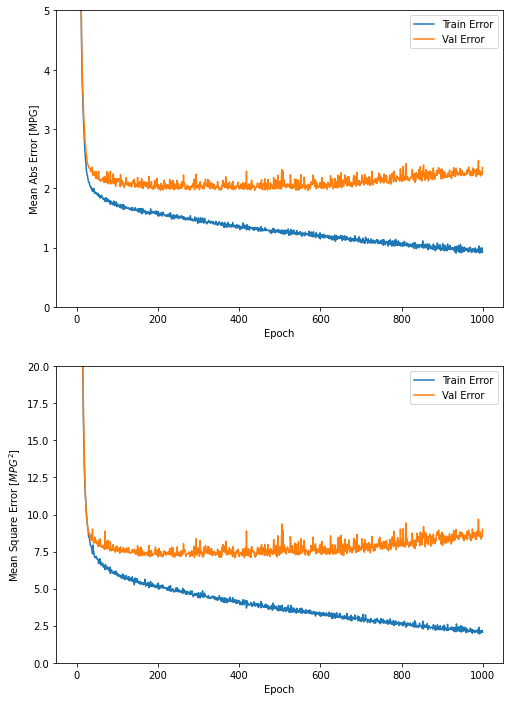

In [45]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

그래프를 확인해보니 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것을 확인했습니다.<br>EarlyStopping 콜백(callback)을 사용하여 에포크 수를 줄이겠습니다.


..................................................................

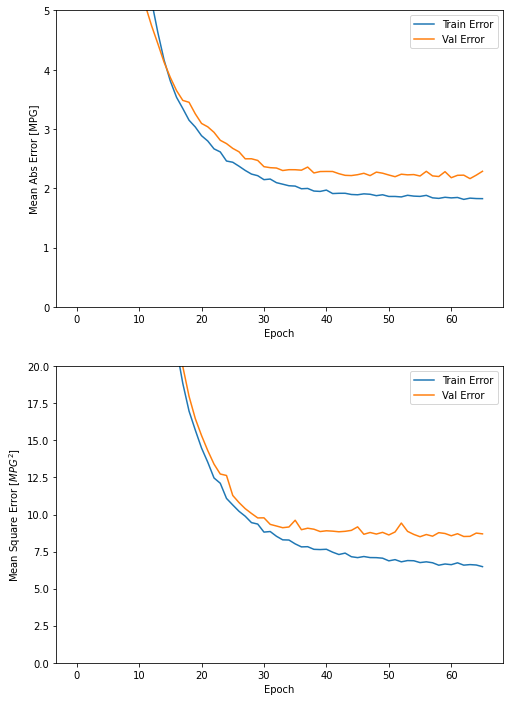

In [46]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# patience는 기준되는 값이 연속으로 몇 번 이상 향상되지 않을 때 종료시킬 것인지를 뜻함.

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [47]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.9701 - mae: 1.8351 - mse: 5.9701 - 21ms/epoch - 7ms/step
테스트 세트의 평균 절대 오차:  1.84 MPG


# 결과 보고
머신 러닝에서는 K-Fold를 사용하여 적은 데이터 수를 보완하며 학습했지만 최종 학습 결과는 딥러닝이 더 좋은 학습 결과를 보여주고 현재 만든 딥러닝은 얕은 수준이겠지만, 머신러닝의 모델 성능의 결과치를 상회함. 

# 한계점
얕은 배움으로 인해 프로젝트 가이드에 언급된 "관심 데이터"로 학습을 진행할 수가 없었습니다. NLP 혹은 이미지 데이터로 뭔가를 진행하고 싶었지만, 레퍼런스를 보고도 명확하게 이해를 하지못해 그대로 옮겨쓰는 수준 밖에 할 수 없었습니다. 결과적으로 프로젝트에서의 시간이 부족하다는 느낌보다는 배울 때 명확히 이해하지 못한 것이 프로젝트에서 좀 버거운 느낌을 만들었다고 생각합니다.

# 해결 방안
부트캠프가 끝난 후, 처음부터 보충해야할 것 같습니다. 프로젝트 직전에 구매한 책들로 시간에 쫓기는 느낌은 조금 지운채로 공부해보려 합니다. 또, 이번 프로젝트 기간에 데이콘, 캐글을 많이 들어가봤는데 간단한 데이터들을 공유 코드로 하나하나 뜯어보며 클론 코딩을 진행하는 것도 학습에 도움이 많이 될 것 같아 진행해보려 합니다.

# Reference

1. Do it! 딥러닝 교과서
2. 케라스 창시자에게 배우는 딥러닝
3. https://www.tensorflow.org/tutorials/keras